# 1st Place Solution Training & Testing Code

Hi, all,

We're very exciting to writing this notebook and the summary of our solution here.

This is a small version (b3 w/ input size 256 training for only 5 epochs) of our training & testing pipeline only for demonstrating our ideas and methods.

To get a similar result of a single model to ours, you only need to do:

* set `DEBUG` to `False`
* train for 15 epochs for each fold
* using apex
* change the model type to effnet-b4/b5/b6/b7
* modify the input size to 384 or 512 or 640 (do remember to use bigger dataset as well)
* keep batch size >= 36 (may have to use multi-gpus)

Our brief summary of winning solution:
https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/175412


# Main Ideas

* apex amp (install apex into kaggle kernel is hard, so I skipped it)
* use meta data
* optimized augmentation methods
* 9 classes w/ CrossEntropyLoss
* warmup + cosine scheduler
* rank per fold before ensemble

# Thanks!

In [1]:
DEBUG = True

In [2]:
!pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip -q install geffnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import os
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr
import albumentations as A
import geffnet

device = torch.device('cuda')

# Config

In [4]:
kernel_type = 'effnetb3_256_meta_9c_ext_5epo'
image_size = 256
use_amp = False
data_dir = '../input/jpeg-melanoma-256x256'
data_dir2 = '../input/jpeg-isic2019-256x256'
enet_type = 'efficientnet-b3'
batch_size = 64
num_workers = 4
init_lr = 3e-5
out_dim = 9

freeze_epo = 0
warmup_epo = 1
cosine_epo = 4
n_epochs = freeze_epo + warmup_epo + cosine_epo

use_external = '_ext' in kernel_type
use_meta = 'meta' in kernel_type

# Read CSV & Target Preprocess

In [5]:
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(data_dir, 'test', f'{x}.jpg'))

In [6]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_train = df_train[df_train['tfrecord'] != -1].reset_index(drop=True)
# df_train['fold'] = df_train['tfrecord'] % 5
tfrecord2fold = {
    2:0, 4:0, 5:0,
    1:1, 10:1, 13:1,
    0:2, 9:2, 12:2,
    3:3, 8:3, 11:3,
    6:4, 7:4, 14:4,
}
df_train['fold'] = df_train['tfrecord'].map(tfrecord2fold)
df_train['is_ext'] = 0
df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join(data_dir, 'train', f'{x}.jpg'))


df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))

df_train['diagnosis'].value_counts()

unknown     26699
nevus        5191
melanoma      581
BKL           221
Name: diagnosis, dtype: int64

In [7]:
if use_external:
    df_train2 = pd.read_csv(os.path.join(data_dir2, 'train.csv'))
    df_train2 = df_train2[df_train2['tfrecord'] >= 0].reset_index(drop=True)
    df_train2['fold'] = df_train2['tfrecord'] % 5
    df_train2['is_ext'] = 1
    df_train2['filepath'] = df_train2['image_name'].apply(lambda x: os.path.join(data_dir2, 'train', f'{x}.jpg'))

    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))
    df_train = pd.concat([df_train, df_train2]).reset_index(drop=True)

diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)
mel_idx = diagnosis2idx['melanoma']
diagnosis2idx

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'SCC': 4,
 'VASC': 5,
 'melanoma': 6,
 'nevus': 7,
 'unknown': 8}

In [8]:
df_train['target'].value_counts()

8    26699
7    18031
6     5090
1     3320
2     2837
0      867
4      628
5      253
3      239
Name: target, dtype: int64

# Preprocess Meta Data

In [9]:
df_train.filepath

0        ../input/jpeg-melanoma-256x256/train/ISIC_2637...
1        ../input/jpeg-melanoma-256x256/train/ISIC_0015...
2        ../input/jpeg-melanoma-256x256/train/ISIC_0052...
3        ../input/jpeg-melanoma-256x256/train/ISIC_0068...
4        ../input/jpeg-melanoma-256x256/train/ISIC_0074...
                               ...                        
57959    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
57960    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
57961    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
57962    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
57963    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
Name: filepath, Length: 57964, dtype: object

In [10]:
if use_meta:
    # One-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([df_train['anatom_site_general_challenge'], df_test['anatom_site_general_challenge']], ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    df_train = pd.concat([df_train, dummies.iloc[:df_train.shape[0]]], axis=1)
    df_test = pd.concat([df_test, dummies.iloc[df_train.shape[0]:].reset_index(drop=True)], axis=1)
    # Sex features
    df_train['sex'] = df_train['sex'].map({'male': 1, 'female': 0})
    df_test['sex'] = df_test['sex'].map({'male': 1, 'female': 0})
    df_train['sex'] = df_train['sex'].fillna(-1)
    df_test['sex'] = df_test['sex'].fillna(-1)
    # Age features
    df_train['age_approx'] /= 90
    df_test['age_approx'] /= 90
    df_train['age_approx'] = df_train['age_approx'].fillna(0)
    df_test['age_approx'] = df_test['age_approx'].fillna(0)
    df_train['patient_id'] = df_train['patient_id'].fillna(0)
    # n_image per user
    df_train['n_images'] = df_train.patient_id.map(df_train.groupby(['patient_id']).image_name.count())
    df_test['n_images'] = df_test.patient_id.map(df_test.groupby(['patient_id']).image_name.count())
    df_train.loc[df_train['patient_id'] == -1, 'n_images'] = 1
    df_train['n_images'] = np.log1p(df_train['n_images'].values)
    df_test['n_images'] = np.log1p(df_test['n_images'].values)
    # image size
    train_images = df_train['filepath'].values
    train_sizes = np.zeros(train_images.shape[0])
    for i, img_path in enumerate(tqdm(train_images)):
        train_sizes[i] = os.path.getsize(img_path)
    df_train['image_size'] = np.log(train_sizes)
    test_images = df_test['filepath'].values
    test_sizes = np.zeros(test_images.shape[0])
    for i, img_path in enumerate(tqdm(test_images)):
        test_sizes[i] = os.path.getsize(img_path)
    df_test['image_size'] = np.log(test_sizes)
    meta_features = ['sex', 'age_approx', 'n_images', 'image_size'] + [col for col in df_train.columns if col.startswith('site_')]
    n_meta_features = len(meta_features)
else:
    n_meta_features = 0

In [11]:
n_meta_features

14

# Define Dataset

In [12]:
class SIIMISICDataset(Dataset):
    def __init__(self, csv, split, mode, transform=None):

        self.csv = csv.reset_index(drop=True)
        self.split = split
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        
        image = cv2.imread(row.filepath)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)

        if use_meta:
            data = (torch.tensor(image).float(), torch.tensor(self.csv.iloc[index][meta_features]).float())
        else:
            data = torch.tensor(image).float()

        if self.mode == 'test':
            return data
        else:
            return data, torch.tensor(self.csv.iloc[index].target).long()

# Augmentations

In [13]:
transforms_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.2, p=0.75),
    A.RandomContrast(limit=0.2, p=0.75),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),

    A.CLAHE(clip_limit=4.0, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
    A.Resize(image_size, image_size),
    A.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),    
    A.Normalize()
])

transforms_val = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize()
])

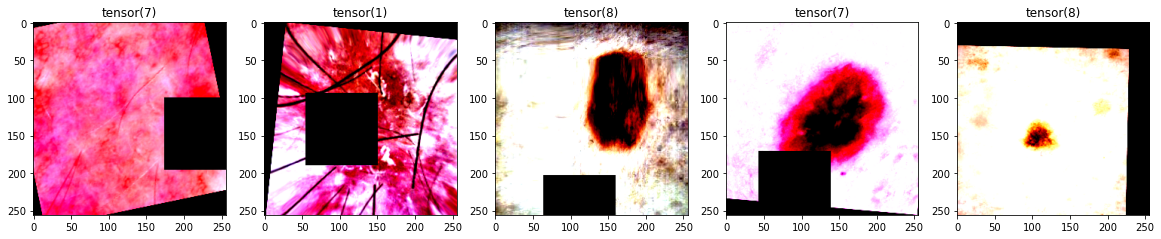

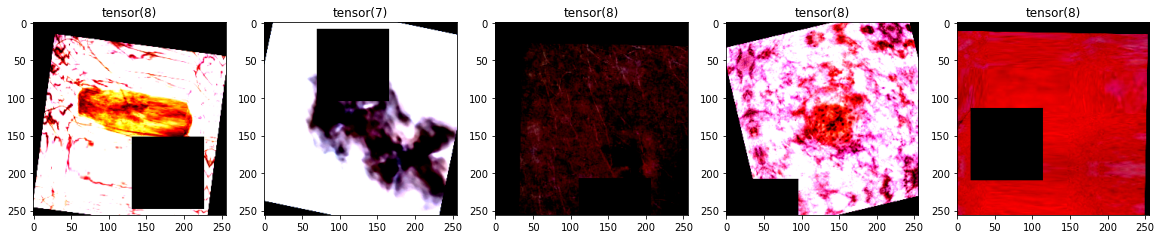

In [14]:
df_show = df_train.sample(1000)
dataset_show = SIIMISICDataset(df_show, 'train', 'train', transform=transforms_train)

from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        if use_meta:
            img = img[0]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

# Model

In [15]:
sigmoid = torch.nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)
swish_layer = Swish_module()

class enetv2(nn.Module):
    def __init__(self, backbone, out_dim, n_meta_features=0, load_pretrained=True):

        super(enetv2, self).__init__()
        self.n_meta_features = n_meta_features
        self.enet = geffnet.create_model(enet_type.replace('-', '_'), pretrained=True)
        self.dropout = nn.Dropout(0.5)
        in_ch = self.enet.classifier.in_features
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, 512),
                nn.BatchNorm1d(512),
                Swish_module(),
                nn.Dropout(p=0.3),
                nn.Linear(512, 128),
                nn.BatchNorm1d(128),
                Swish_module(),
            )
            in_ch += 128
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        if self.n_meta_features > 0:
            x_meta = self.meta(x_meta)
            x = torch.cat((x, x_meta), dim=1)
            x = self.myfc(self.dropout(x))
        return x

# Loss Function

In [16]:
criterion = nn.CrossEntropyLoss()

# Train & Valid Function

In [17]:
def train_epoch(model, loader, optimizer):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        optimizer.zero_grad()
        if use_meta:
            data, meta = data
            data, meta, target = data.to(device), meta.to(device), target.to(device)
            logits = model(data, meta)
        else:
            data, target = data.to(device), target.to(device)
            logits = model(data)
        loss = criterion(logits, target)

        if not use_amp:
            loss.backward()
        else:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()

        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

    
def val_epoch(model, loader, is_ext=None, n_test=1, get_output=False):
    model.eval()
    val_loss = []
    LOGITS = []
    PROBS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            
            if use_meta:
                data, meta = data
                data, meta, target = data.to(device), meta.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I), meta)
                    logits += l
                    probs += l.softmax(1)
            else:
                data, target = data.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I))
                    logits += l
                    probs += l.softmax(1)
            logits /= n_test
            probs /= n_test

            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

            loss = criterion(logits, target)
            val_loss.append(loss.detach().cpu().numpy())

    val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()

    if get_output:
        return PROBS
    else:
        acc = (PROBS.argmax(1) == TARGETS).mean() * 100.
        auc = roc_auc_score((TARGETS==mel_idx).astype(float), PROBS[:, mel_idx])
        auc_20 = roc_auc_score((TARGETS[is_ext==0]==mel_idx).astype(float), PROBS[is_ext==0, mel_idx])
        return val_loss, acc, auc, auc_20

In [18]:
# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [19]:
def run(fold):
    
    i_fold = fold

    if DEBUG:
        df_this = df_train[df_train['fold'] != i_fold].sample(batch_size * 3)
        df_valid = df_train[df_train['fold'] == i_fold].sample(batch_size * 3)
    else:
        df_this = df_train[df_train['fold'] != i_fold]
        df_valid = df_train[df_train['fold'] == i_fold]

    dataset_train = SIIMISICDataset(df_this,  'train', 'train', transform=transforms_train)
    dataset_valid = SIIMISICDataset(df_valid, 'train', 'val', transform=transforms_val)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, num_workers=num_workers)

    model = enetv2(enet_type, n_meta_features=n_meta_features, out_dim=out_dim)
    model = model.to(device)

    auc_max = 0.
    auc_20_max = 0.
    model_file = f'{kernel_type}_best_fold{i_fold}.pth'
    model_file2 = f'{kernel_type}_best_o_fold{i_fold}.pth'

    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    if use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss, acc, auc, auc_20 = val_epoch(model, valid_loader, is_ext=df_valid['is_ext'].values)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}, auc_20: {(auc_20):.6f}.'
        print(content)
        with open(f'log_{kernel_type}.txt', 'a') as appender:
            appender.write(content + '\n')

        if auc > auc_max:
            print('auc_max ({:.6f} --> {:.6f}). Saving model ...'.format(auc_max, auc))
            torch.save(model.state_dict(), model_file)
            auc_max = auc
        if auc_20 > auc_20_max:
            print('auc_20_max ({:.6f} --> {:.6f}). Saving model ...'.format(auc_20_max, auc_20))
            torch.save(model.state_dict(), model_file2)
            auc_20_max = auc_20

    scores.append(auc_max)
    scores_20.append(auc_20_max)
    torch.save(model.state_dict(), os.path.join(f'{kernel_type}_model_fold{i_fold}.pth'))

# Run 5-Fold Training

In [20]:
scores = []
scores_20 = []

In [21]:
for fold in range(5):
    run(fold)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra-a5e2fbc7.pth" to /root/.cache/torch/checkpoints/efficientnet_b3_ra-a5e2fbc7.pth


192 192
Wed Aug 19 15:06:59 2020 Epoch: 1


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:07:08 2020 Fold 0, Epoch 1, lr: 0.0000300, train loss: 2.21770, valid loss: 2.35197, acc: 2.6042, auc: 0.492655, auc_20: 0.389423.
auc_max (0.000000 --> 0.492655). Saving model ...
auc_20_max (0.000000 --> 0.389423). Saving model ...
Wed Aug 19 15:07:08 2020 Epoch: 2


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:07:15 2020 Fold 0, Epoch 2, lr: 0.0003000, train loss: 2.03782, valid loss: 2.08930, acc: 28.6458, auc: 0.585687, auc_20: 0.519231.
auc_max (0.492655 --> 0.585687). Saving model ...
auc_20_max (0.389423 --> 0.519231). Saving model ...
Wed Aug 19 15:07:16 2020 Epoch: 3


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:07:23 2020 Fold 0, Epoch 3, lr: 0.0003000, train loss: 1.69699, valid loss: 1.77410, acc: 60.4167, auc: 0.700188, auc_20: 0.774038.
auc_max (0.585687 --> 0.700188). Saving model ...
auc_20_max (0.519231 --> 0.774038). Saving model ...
Wed Aug 19 15:07:23 2020 Epoch: 4


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:07:30 2020 Fold 0, Epoch 4, lr: 0.0001500, train loss: 1.46860, valid loss: 1.55121, acc: 65.6250, auc: 0.767608, auc_20: 0.870192.
auc_max (0.700188 --> 0.767608). Saving model ...
auc_20_max (0.774038 --> 0.870192). Saving model ...
Wed Aug 19 15:07:30 2020 Epoch: 5


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:07:38 2020 Fold 0, Epoch 5, lr: 0.0000439, train loss: 1.34746, valid loss: 1.44958, acc: 67.1875, auc: 0.786817, auc_20: 0.884615.
auc_max (0.767608 --> 0.786817). Saving model ...
auc_20_max (0.870192 --> 0.884615). Saving model ...
192 192
Wed Aug 19 15:07:38 2020 Epoch: 1


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:07:46 2020 Fold 1, Epoch 1, lr: 0.0000300, train loss: 2.20374, valid loss: 2.06638, acc: 29.6875, auc: 0.659160, auc_20: 0.949686.
auc_max (0.000000 --> 0.659160). Saving model ...
auc_20_max (0.000000 --> 0.949686). Saving model ...
Wed Aug 19 15:07:46 2020 Epoch: 2


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:07:53 2020 Fold 1, Epoch 2, lr: 0.0003000, train loss: 2.02336, valid loss: 1.89031, acc: 58.8542, auc: 0.730420, auc_20: 0.669811.
auc_max (0.659160 --> 0.730420). Saving model ...
Wed Aug 19 15:07:53 2020 Epoch: 3


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:08:00 2020 Fold 1, Epoch 3, lr: 0.0003000, train loss: 1.66623, valid loss: 1.64756, acc: 65.6250, auc: 0.748571, auc_20: 0.534591.
auc_max (0.730420 --> 0.748571). Saving model ...
Wed Aug 19 15:08:01 2020 Epoch: 4


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:08:08 2020 Fold 1, Epoch 4, lr: 0.0001500, train loss: 1.40713, valid loss: 1.49207, acc: 65.1042, auc: 0.778487, auc_20: 0.591195.
auc_max (0.748571 --> 0.778487). Saving model ...
Wed Aug 19 15:08:08 2020 Epoch: 5


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:08:15 2020 Fold 1, Epoch 5, lr: 0.0000439, train loss: 1.28982, valid loss: 1.43837, acc: 65.1042, auc: 0.788235, auc_20: 0.641509.
auc_max (0.778487 --> 0.788235). Saving model ...
192 192
Wed Aug 19 15:08:16 2020 Epoch: 1


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:08:23 2020 Fold 2, Epoch 1, lr: 0.0000300, train loss: 2.20749, valid loss: 2.21307, acc: 6.2500, auc: 0.598366, auc_20: 0.482866.
auc_max (0.000000 --> 0.598366). Saving model ...
auc_20_max (0.000000 --> 0.482866). Saving model ...
Wed Aug 19 15:08:23 2020 Epoch: 2


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:08:30 2020 Fold 2, Epoch 2, lr: 0.0003000, train loss: 2.09504, valid loss: 2.01355, acc: 46.3542, auc: 0.719815, auc_20: 0.654206.
auc_max (0.598366 --> 0.719815). Saving model ...
auc_20_max (0.482866 --> 0.654206). Saving model ...
Wed Aug 19 15:08:30 2020 Epoch: 3


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:08:38 2020 Fold 2, Epoch 3, lr: 0.0003000, train loss: 1.69928, valid loss: 1.72905, acc: 60.4167, auc: 0.783381, auc_20: 0.781931.
auc_max (0.719815 --> 0.783381). Saving model ...
auc_20_max (0.654206 --> 0.781931). Saving model ...
Wed Aug 19 15:08:38 2020 Epoch: 4


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:08:45 2020 Fold 2, Epoch 4, lr: 0.0001500, train loss: 1.42994, valid loss: 1.51120, acc: 67.1875, auc: 0.796520, auc_20: 0.850467.
auc_max (0.783381 --> 0.796520). Saving model ...
auc_20_max (0.781931 --> 0.850467). Saving model ...
Wed Aug 19 15:08:45 2020 Epoch: 5


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:08:54 2020 Fold 2, Epoch 5, lr: 0.0000439, train loss: 1.32272, valid loss: 1.41666, acc: 69.7917, auc: 0.807173, auc_20: 0.906542.
auc_max (0.796520 --> 0.807173). Saving model ...
auc_20_max (0.850467 --> 0.906542). Saving model ...
192 192
Wed Aug 19 15:08:54 2020 Epoch: 1


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:09:02 2020 Fold 3, Epoch 1, lr: 0.0000300, train loss: 2.23589, valid loss: 2.15555, acc: 15.6250, auc: 0.423355, auc_20: 0.162162.
auc_max (0.000000 --> 0.423355). Saving model ...
auc_20_max (0.000000 --> 0.162162). Saving model ...
Wed Aug 19 15:09:02 2020 Epoch: 2


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:09:10 2020 Fold 3, Epoch 2, lr: 0.0003000, train loss: 2.03360, valid loss: 2.00577, acc: 44.2708, auc: 0.452648, auc_20: 0.108108.
auc_max (0.423355 --> 0.452648). Saving model ...
Wed Aug 19 15:09:10 2020 Epoch: 3


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:09:18 2020 Fold 3, Epoch 3, lr: 0.0003000, train loss: 1.67894, valid loss: 1.76296, acc: 61.9792, auc: 0.583467, auc_20: 0.198198.
auc_max (0.452648 --> 0.583467). Saving model ...
auc_20_max (0.162162 --> 0.198198). Saving model ...
Wed Aug 19 15:09:18 2020 Epoch: 4


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:09:25 2020 Fold 3, Epoch 4, lr: 0.0001500, train loss: 1.41296, valid loss: 1.58179, acc: 66.6667, auc: 0.670947, auc_20: 0.432432.
auc_max (0.583467 --> 0.670947). Saving model ...
auc_20_max (0.198198 --> 0.432432). Saving model ...
Wed Aug 19 15:09:26 2020 Epoch: 5


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:09:33 2020 Fold 3, Epoch 5, lr: 0.0000439, train loss: 1.29496, valid loss: 1.50455, acc: 69.2708, auc: 0.719101, auc_20: 0.558559.
auc_max (0.670947 --> 0.719101). Saving model ...
auc_20_max (0.432432 --> 0.558559). Saving model ...
192 192
Wed Aug 19 15:09:34 2020 Epoch: 1


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:09:41 2020 Fold 4, Epoch 1, lr: 0.0000300, train loss: 2.21838, valid loss: 2.14639, acc: 25.5208, auc: 0.547867, auc_20: 0.343137.
auc_max (0.000000 --> 0.547867). Saving model ...
auc_20_max (0.000000 --> 0.343137). Saving model ...
Wed Aug 19 15:09:41 2020 Epoch: 2


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:09:48 2020 Fold 4, Epoch 2, lr: 0.0003000, train loss: 2.01849, valid loss: 1.94944, acc: 42.7083, auc: 0.600942, auc_20: 0.392157.
auc_max (0.547867 --> 0.600942). Saving model ...
auc_20_max (0.343137 --> 0.392157). Saving model ...
Wed Aug 19 15:09:49 2020 Epoch: 3


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:09:56 2020 Fold 4, Epoch 3, lr: 0.0003000, train loss: 1.64337, valid loss: 1.65609, acc: 61.4583, auc: 0.625496, auc_20: 0.627451.
auc_max (0.600942 --> 0.625496). Saving model ...
auc_20_max (0.392157 --> 0.627451). Saving model ...
Wed Aug 19 15:09:56 2020 Epoch: 4


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:10:03 2020 Fold 4, Epoch 4, lr: 0.0001500, train loss: 1.38728, valid loss: 1.46765, acc: 63.0208, auc: 0.652778, auc_20: 0.696078.
auc_max (0.625496 --> 0.652778). Saving model ...
auc_20_max (0.627451 --> 0.696078). Saving model ...
Wed Aug 19 15:10:04 2020 Epoch: 5


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()



Wed Aug 19 15:10:11 2020 Fold 4, Epoch 5, lr: 0.0000439, train loss: 1.25154, valid loss: 1.39849, acc: 64.0625, auc: 0.675099, auc_20: 0.725490.
auc_max (0.652778 --> 0.675099). Saving model ...
auc_20_max (0.696078 --> 0.725490). Saving model ...


In [22]:
print(scores)
print(scores_20)

[0.7868173258003767, 0.788235294117647, 0.8071732954545454, 0.7191011235955056, 0.6750992063492063]
[0.8846153846153846, 0.949685534591195, 0.9065420560747663, 0.5585585585585586, 0.7254901960784313]


# Get OOF and CV score

In [23]:
PROBS = []
dfs = []

for fold in range(5):
    i_fold = fold

    df_valid = df_train[df_train['fold'] == i_fold]
    dataset_valid = SIIMISICDataset(df_valid, 'train', 'val', transform=transforms_val)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, num_workers=num_workers)

    model = enetv2(enet_type, n_meta_features=n_meta_features, out_dim=out_dim)
    model = model.to(device)
    model_file = f'{kernel_type}_best_fold{i_fold}.pth'
    model.load_state_dict(torch.load(model_file), strict=True)
    model.eval()

    this_PROBS = val_epoch(model, valid_loader, is_ext=df_valid['is_ext'].values, n_test=8, get_output=True)
    PROBS.append(this_PROBS)
    dfs.append(df_valid)

dfs = pd.concat(dfs).reset_index(drop=True)
dfs['pred'] = np.concatenate(PROBS).squeeze()[:, mel_idx]

In [24]:
# Raw auc_all
roc_auc_score(dfs['target'] == mel_idx, dfs['pred'])

0.7612732010778785

In [25]:
# Rank per fold auc_all
dfs2 = dfs.copy()
for i in range(5):
    dfs2.loc[dfs2['fold']==i, 'pred'] = dfs2.loc[dfs2['fold']==i, 'pred'].rank(pct=True)
roc_auc_score(dfs2['target'] == mel_idx, dfs2['pred'])

0.7680437769058115

In [26]:
# Raw auc_2020
roc_auc_score(dfs[dfs['is_ext']==0]['target']==mel_idx, dfs[dfs['is_ext']==0]['pred'])

0.6760197831414279

In [27]:
# Rank per fold auc_2020
dfs2 = dfs[dfs.is_ext==0].copy()
for i in range(5):
    dfs2.loc[dfs2['fold']==i, 'pred'] = dfs2.loc[dfs2['fold']==i, 'pred'].rank(pct=True)
roc_auc_score(dfs2['target'] == mel_idx, dfs2['pred'])

0.6897362960698237

# Predict

In [28]:
n_test = 8
dataset_test = SIIMISICDataset(df_test, 'test', 'test', transform=transforms_val)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers)

In [29]:
OUTPUTS = []

for fold in range(5):
    model = enetv2(enet_type, n_meta_features=n_meta_features, out_dim=out_dim)
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join('%s_best_fold%s.pth' % (kernel_type, fold))), strict=True)
    model.eval()
    
    LOGITS = []
    PROBS = []

    with torch.no_grad():
        for (data) in tqdm(test_loader):
            
            if use_meta:
                data, meta = data
                data, meta = data.to(device), meta.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I), meta)
                    logits += l
                    probs += l.softmax(1)
            else:
                data = data.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I))
                    logits += l
                    probs += l.softmax(1)
            logits /= n_test
            probs /= n_test
    
            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())

    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    
    OUTPUTS.append(PROBS[:, mel_idx])

In [30]:
# Rank per fold
pred = np.zeros(OUTPUTS[0].shape[0])
for probs in OUTPUTS:
    pred += pd.Series(probs).rank(pct=True).values
pred /= len(OUTPUTS)

# Submit to Kaggle

In [31]:
df_test['target'] = pred
df_test[['image_name', 'target']].to_csv(f'submission.csv', index=False)

In [32]:
df_test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height,filepath,site_anterior torso,site_head/neck,...,site_lower extremity,site_oral/genital,site_palms/soles,site_posterior torso,site_torso,site_upper extremity,site_nan,n_images,image_size,target
0,ISIC_0052060,IP_3579794,1,0.777778,NaN,6000,4000,../input/jpeg-melanoma-256x256/test/ISIC_00520...,0,0,...,0,0,0,0,0,0,1,5.484797,10.395864,0.236460
1,ISIC_0052349,IP_7782715,1,0.444444,lower extremity,6000,4000,../input/jpeg-melanoma-256x256/test/ISIC_00523...,0,0,...,1,0,0,0,0,0,0,3.850148,9.786279,0.051994
2,ISIC_0058510,IP_7960270,0,0.611111,torso,6000,4000,../input/jpeg-melanoma-256x256/test/ISIC_00585...,0,0,...,0,0,0,0,1,0,0,3.367296,9.594378,0.312439
3,ISIC_0073313,IP_6375035,0,0.555556,torso,6000,4000,../input/jpeg-melanoma-256x256/test/ISIC_00733...,0,0,...,0,0,0,0,1,0,0,3.663562,9.607504,0.414934
4,ISIC_0073502,IP_0589375,0,0.500000,lower extremity,1920,1080,../input/jpeg-melanoma-256x256/test/ISIC_00735...,0,0,...,1,0,0,0,0,0,0,3.401197,9.555135,0.447969
